### Load Data

In [21]:
import pandas as pd
import numpy as np

df_attributes = pd.read_csv('dataset/stories_attributes.csv')
df_text = pd.read_csv('dataset/stories_in_text.csv')

df = pd.merge(df_attributes, df_text, on=['filename', 'Language'])
# 0 = truth, 1 = deceptive
df['label'] = np.where(df['Story_type'] == 'Deceptive Story', 1, 0)
df['idx'] = range(len(df))
df = df.drop(columns=['Story_type'])
df

,filename,Language,text,label,idx
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,0,0
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,0,1
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,0,2
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,0,3
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,0,4
...,...,...,...,...,...
95,00096.wav,English,Uh. \nW is a\n uh my friends and I decided to...,0,95
96,00097.wav,Chinese,上周\n我前往宜家\n孤儿院\n去看望我大学时期志愿服务时认识的小男孩，\n浩浩，\n那是一...,1,96
97,00098.wav,Chinese,呃上个周末我和我的朋友们准备去参加一场徒步旅行，\n然后目标是一片森林，\n那天的天气比较阴...,0,97
98,00099.wav,Chinese,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，\n我们都挺喜欢艺术的，所以就提前计...,1,98


### Features from Text

In [22]:
feats = {
    'idx': df['idx'], 
    'is_cn': df['Language'] == 'Chinese', 
    'length': df['text'].apply(len)
}

df_feats = pd.DataFrame(feats)
df_feats

,idx,is_cn,length
0,0,True,494
1,1,True,498
2,2,True,584
3,3,True,666
4,4,True,492
...,...,...,...
95,95,False,1040
96,96,True,648
97,97,True,476
98,98,True,488


### Do Boosting

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

USE_XGB = False
USE_LGBM = True
USE_STACKING = False
N_JOBS = 8

X = df_feats
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

base_models = []
if USE_XGB:
    base_models.append(('xgboost', XGBClassifier(
        random_state=0,
        n_jobs=N_JOBS,
        tree_method='gpu_hist',
        gpu_id=0,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )))
if USE_LGBM:
    base_models.append(('lightgbm', LGBMClassifier(
        device='gpu',
        random_state=0,
        n_jobs=N_JOBS,
        verbose=-1
    )))

if USE_STACKING and len(base_models) > 1:
    print(f"Stacking [{', '.join([name for name, _ in base_models])}]")
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(random_state=0, n_jobs=N_JOBS),
        passthrough=False,
        cv=5,
        n_jobs=N_JOBS
    )
    clf = OneVsRestClassifier(stacking_clf, n_jobs=N_JOBS)
else:
    print(f"Using {base_models[0][0]}")
    clf = OneVsRestClassifier(base_models[0][1], n_jobs=N_JOBS)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Report:")
print(classification_report(y_test, y_pred))

Using lightgbm
Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20




Feature Importance:
Feature  Importance
 length         105
    idx          65
  is_cn          30


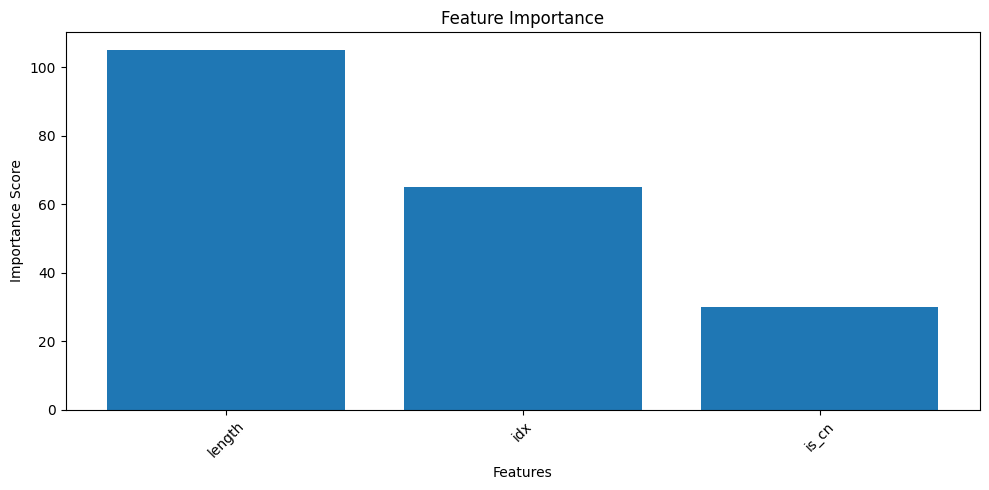

In [24]:
import matplotlib.pyplot as plt

feature_importance = clf.estimators_[0].feature_importances_
feature_names = df_feats.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df_importance['Feature'], df_importance['Importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()

# Print table
print("\nFeature Importance:")
print(df_importance.to_string(index=False))